In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
import sys
import pathlib
import functools
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchvision.transforms import *
import time
import pandas as pd

In [12]:
sys.path.insert(0,'/home')
from data import HCP_MRI_reshape

In [13]:
import nilearn
from nilearn import plotting
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
data_dir = pathlib.Path('/data/adni')

In [15]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
# plot_central_cuts(nilearn.image.get_data(img)[np.newaxis,:], title="ex", t = None)
# plot_central_cuts(img_crop, title="ex", t = None)

In [16]:
# PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join('/data/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'
PATH_TO_MRI = '/home/crop_data_resize'

In [17]:
df = pd.read_csv(behavioral_path)

In [18]:
df_M = df.loc[df["Gender"]=='M']
df_F = df.loc[df["Gender"]=='F']

In [19]:
len(df_M), len(df_F)

(507, 606)

[[0.04830803 0.04363399 0.0470521  0.03919343 0.03991126 0.04725897
  0.04340179 0.04500459 0.04502758 0.04656832 0.04866149 0.04421791
  0.04688163 0.04089411 0.04425105 0.05065185 0.04213286 0.04854298
  0.04010639 0.04511566 0.04557064 0.04057667 0.04607948 0.0478392
  0.04712877 0.04149584 0.0460737  0.04649245 0.04434467 0.05164315
  0.04715097 0.04527358 0.04991893 0.04250904 0.04085596 0.04278771
  0.0433241  0.04503826 0.0449632  0.04286035 0.04129995 0.04794592
  0.04588312 0.04230494 0.04622436 0.04161535 0.04032953 0.04807054
  0.04201156 0.04430893 0.04268527 0.03894353 0.04475426 0.04501713
  0.0365562  0.04947134 0.0455473  0.0406757  0.0468442  0.04753842
  0.04194263 0.04221255 0.04385885 0.04515856 0.0397994  0.04982072
  0.04534627 0.04674193 0.04511994 0.04554433 0.04384245 0.04708857
  0.0467256  0.04056869 0.04033339 0.04268429 0.04571665 0.04360597
  0.04587237 0.04459423 0.04608417 0.04623703 0.04116518 0.04336582
  0.03892799 0.04650279 0.03919322 0.03921983 0.0

(array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.02781745, 0.03058853, 0.03335961, 0.03613069, 0.03890178,
        0.04167286, 0.04444394, 0.04721502, 0.0499861 , 0.05275719,
        0.05552827]),
 <a list of 507 BarContainer objects>)

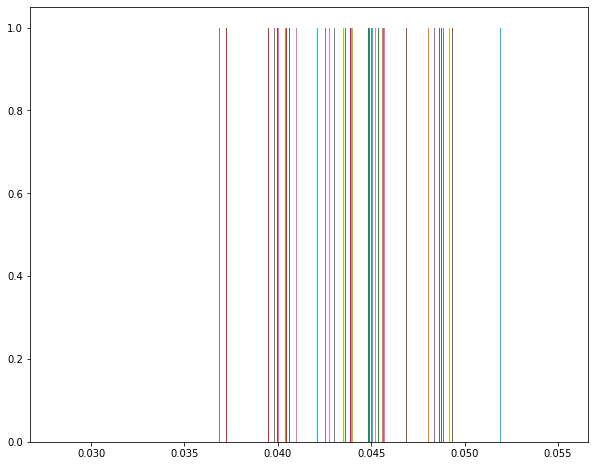

In [39]:
norm_M = preprocessing.normalize(df_M['FS_InterCranial_Vol'].values.reshape(1,-1))
print(norm_M)
fig = plt.figure(figsize=(10,8))
plt.hist(norm_M)

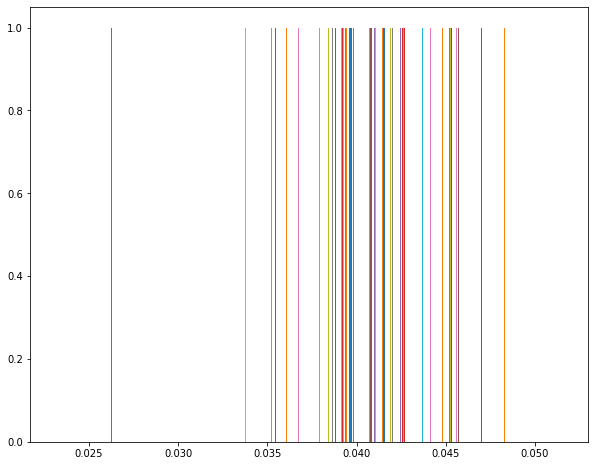

In [46]:
norm_F = preprocessing.normalize(df_F['FS_InterCranial_Vol'].values.reshape(1,-1))
fig = plt.figure(figsize=(10,8))
plt.hist(norm_F)
plt.show()

In [33]:
df_M['FS_InterCranial_Vol'].values.reshape(-1,1).shape

(507,)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='FS_InterCranial_Vol', ylabel='Density'>

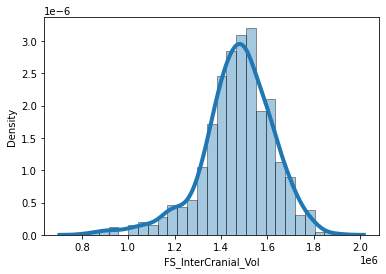

In [47]:

sns.distplot(df_F['FS_InterCranial_Vol'], hist=True, kde=True, hist_kws={'edgecolor':'black'}, kde_kws={'linewidth':4})

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='FS_InterCranial_Vol', ylabel='Density'>

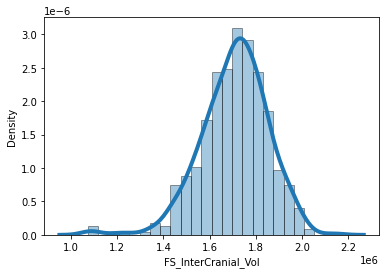

In [48]:
sns.distplot(df_M['FS_InterCranial_Vol'], hist=True, kde=True, hist_kws={'edgecolor':'black'}, kde_kws={'linewidth':4})

In [50]:
np.std(preprocessing.normalize(df_M['FS_InterCranial_Vol'].values.reshape(1,-1))), np.std(preprocessing.normalize(df_F['FS_InterCranial_Vol'].values.reshape(1,-1)))

(0.0037308829922534236, 0.004209664861207583)

In [52]:
df_M['FS_InterCranial_Vol'].values.reshape(1,-1).shape


(1, 507)

In [53]:
amax = np.max(df_M['FS_InterCranial_Vol'])
amin = np.min(df_M['FS_InterCranial_Vol'])
rang = amax-amin
norm_arr_M = ((df_M['FS_InterCranial_Vol'] - amin)/rang)

In [54]:
norm_arr_M

0       0.739443
2       0.570771
3       0.694121
5       0.410525
6       0.436429
          ...   
1105    0.321629
1106    0.841634
1108    0.416406
1110    0.621163
1111    0.628041
Name: FS_InterCranial_Vol, Length: 507, dtype: float64

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='FS_InterCranial_Vol', ylabel='Density'>

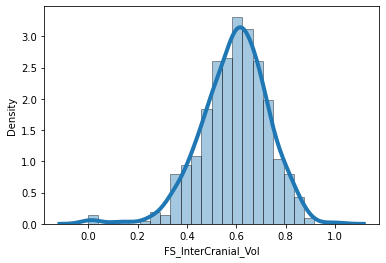

In [58]:
sns.distplot(norm_arr_M, hist=True, hist_kws={'edgecolor':'black'}, kde_kws={'linewidth':4})

In [60]:
amax = np.max(df_F['FS_InterCranial_Vol'])
amin = np.min(df_F['FS_InterCranial_Vol'])
rang = amax-amin
norm_arr_F = ((df_F['FS_InterCranial_Vol'] - amin)/rang)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='FS_InterCranial_Vol', ylabel='Density'>

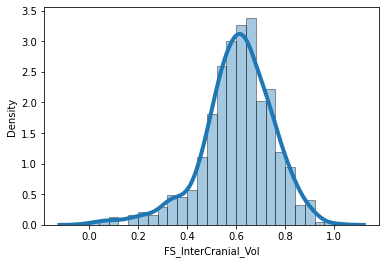

In [61]:
sns.distplot(norm_arr_F, hist=True, hist_kws={'edgecolor':'black'}, kde_kws={'linewidth':4})

In [62]:
np.std(norm_arr_M), np.std(norm_arr_F)

(0.13463633973100164, 0.14508339107444745)

In [63]:
np.mean(norm_arr_M), np.mean(norm_arr_F)

(0.5931662573962596, 0.6057128867553767)

In [70]:
pernorm_arr_F = norm_arr_F*1.2

In [71]:
np.mean(pernorm_arr_F), np.std(pernorm_arr_F)

(0.7268554641064521, 0.17410006928933694)